In [12]:
# visualization
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
fe = fm.FontEntry(
    fname=r'/usr/share/fonts/truetype/nanum/NanumGothic.ttf', # ttf 파일이 저장되어 있는 경로
    name='NanumBarunGothic')                        # 이 폰트의 원하는 이름 설정
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumBarunGothic'}) # 폰트 설정
plt.rc('font', family='NanumBarunGothic')
import seaborn as sns

# utils
import pandas as pd
import numpy as np
from tqdm import tqdm
import pickle
import warnings;warnings.filterwarnings('ignore')

# Model
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics

import eli5
from eli5.sklearn import PermutationImportance

In [13]:
train_path = "../modified_data/v04_train.csv"
test_path = "../modified_data/v04_test.csv"

In [14]:
train = pd.read_csv(train_path, index_col=0)
test = pd.read_csv(test_path,index_col=0)

In [15]:
train["is_test"] = 0
test["is_test"] = 1
concat = pd.concat([train, test])

# 명목형 변수 모으기

In [16]:
column_date = ["k-사용검사일-사용승인일","k-등록일자", "k-수정일자", "단지승인일", "단지신청일"]

for column in column_date:
    print(column, concat[column].dtypes)
    concat[column] = pd.to_datetime(concat[column])
    print(concat[column].dtypes)

continuous_columns = []
categorical_columns = []
for column in concat.columns:
    if pd.api.types.is_numeric_dtype(concat[column]) or pd.api.types.is_datetime64_ns_dtype(concat[column]):
        continuous_columns.append(column)
    else:
        categorical_columns.append(column)

print("연속형 변수:", continuous_columns)
print("범주형 변수:", categorical_columns)

k-사용검사일-사용승인일 object
datetime64[ns]
k-등록일자 object
datetime64[ns]
k-수정일자 object
datetime64[ns]
단지승인일 object
datetime64[ns]
단지신청일 object
datetime64[ns]
연속형 변수: ['본번', '부번', '전용면적(㎡)', '계약년월', '계약일', '층', '건축년도', '등기신청일자', 'k-전체동수', 'k-전체세대수', 'k-사용검사일-사용승인일', 'k-연면적', 'k-주거전용면적', 'k-관리비부과면적', 'k-전용면적별세대현황(60㎡이하)', 'k-전용면적별세대현황(60㎡~85㎡이하)', 'k-85㎡~135㎡이하', 'k-135㎡초과', 'k-등록일자', 'k-수정일자', '건축면적', '주차대수', '단지승인일', '사용허가여부', '관리비 업로드', '좌표X', '좌표Y', '단지신청일', 'target', 'is_test']
범주형 변수: ['번지', '아파트명', '거래유형', 'k-단지분류(아파트,주상복합등등)', 'k-세대타입(분양형태)', 'k-복도유형', 'k-난방방식', 'k-건설사(시공사)', '기타/의무/임대/임의=1/2/3/4', '시', '구', '동']


# 상관계수

In [17]:
from scipy.stats import chi2_contingency

In [18]:
def chi2_test(feature1, feature2):
    contingency_table = pd.crosstab(concat[feature1], concat[feature2])
    chi2, p, dof, expected = chi2_contingency(contingency_table)
    return p

In [19]:
p_values = pd.DataFrame(np.zeros((len(categorical_columns), len(categorical_columns))), columns=categorical_columns, index=categorical_columns)
for f1 in categorical_columns:
    for f2 in categorical_columns:
        p_values.loc[f1, f2] = chi2_test(f1, f2)

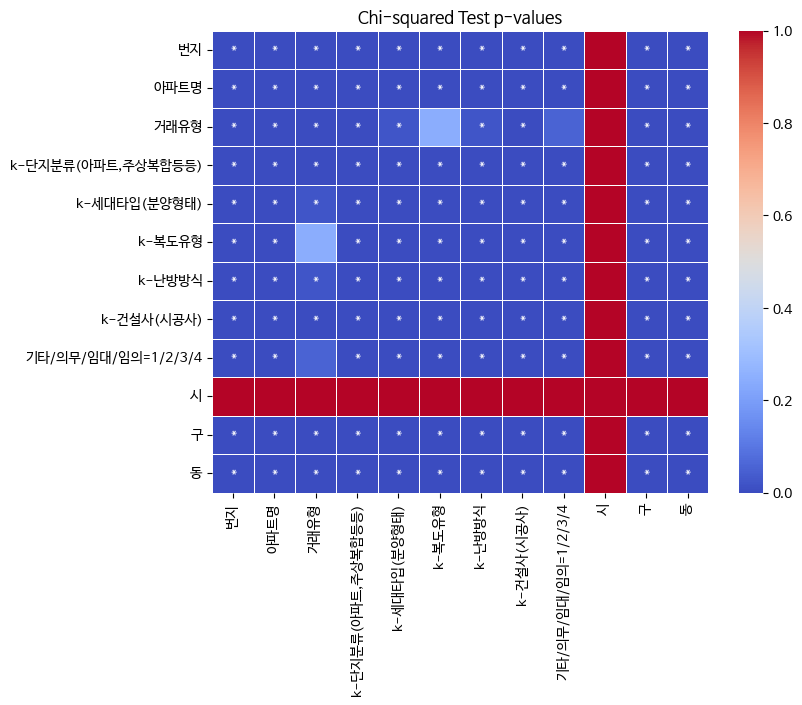

In [20]:
alpha = 0.03
significance_matrix = p_values.applymap(lambda p: '*' if p < alpha else ' ')

# Heatmap 그리기
plt.figure(figsize=(8, 6))
sns.heatmap(p_values, annot=significance_matrix, cmap='coolwarm', fmt='s', linewidths=.5)
plt.title('Chi-squared Test p-values')
plt.show()